# 线性回归 - 图像恢复

# 1. 实验介绍

## 1.1 实验背景
图像是一种非常常见的信息载体，但是在图像的获取、传输、存储的过程中可能由于各种原因使得图像受到噪声的影响。  
如何去除噪声的影响，恢复图像原本的信息是计算机视觉中的重要研究问题。

常见的图像恢复算法有基于空间域的中值滤波、基于小波域的小波去噪、基于偏微分方程的非线性扩散滤波等，在本次实验中，我们要对图像添加噪声，并对添加噪声的图像进行基于线性回归模型的去噪。

## 1.2 实验要求
A. 生成受损图像。
+ 受损图像（X）是由原始图像（$I\in R^{H*W*C}$）添加了不同噪声遮罩（noise masks）（$M\in R^{H*W*C}$）得到的（$X=I \bigodot M$），其中$\bigodot$是逐元素相乘。
+ 噪声遮罩仅包含 {0,1} 值。对原图的噪声遮罩的可以每行分别用 0.8/0.4/0.6 的噪声比率产生的，即噪声遮罩每个通道每行 80%/40%/60% 的像素值为 0，其他为 1。

B. 使用区域二元线性回归模型，进行图像恢复。

C. 评估误差为所有恢复图像（R）与原始图像（I）的 2-范数之和，此误差越小越好。$ \rm error=\sum_{i=1}^{3}norm(R_i(:)-I_i(:),2)$，其中(:)是向量化操作。

## 1.3 实验环境
可以使用基于Python的 [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html) 库进行图像相关处理，使用 [Numpy](https://www.numpy.org/) 库进行相关数值运算。

## 1.4 参考资料
OpenCV：https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html
    
Numpy：https://www.numpy.org/

Scikit-Learn：https://scikit-learn.org/stable/

# 2.实验部分

## 2.1 导入相关包

In [1]:
from matplotlib import pyplot as plt  # 展示图片
import numpy as np  # 数值处理
import cv2  # opencv库
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # 回归分析

## 2.2 读取图片

+ 读取图片我们采用 [cv2.imread(filename[, flags])](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html#display-image) 函数：
    + filename：文件路径
    + flags：指定加载图像颜色类型的标志
        + cv2.IMREAD_COLOR：读入一副彩色图像。图像的透明度会被忽略，这是默认参数，此时 flags=1。
        + cv2.IMREAD_GRAYSCALE：以灰度模式读入图像，此时 flags=0。
        + cv2.IMREAD_UNCHANGED：读入一幅图像，并且包括图像的 alpha 通道，此时 flags=-1。
        
**注意**：就算图像的路径是错的，OpenCV 也不会提醒你的，但是当你使用命令 print(img) 时得到的结果是 None。  

<br>

+ 显示图片使用 Matplotlib，具体可以参见 [Matplotlib docs](https://matplotlib.org/api/pyplot_api.html)。

**注意**：彩色图像使用 OpenCV 加载时是 BGR 模式，但是 Matplotlib 是 RGB 模式。所以彩色图像如果已经被 OpenCV 读取，那它将不会被 Matplotlib 正确显示。因此我们将 BGR模式转换为 RGB 模式即可。

<class 'numpy.ndarray'>


(-0.5, 827.5, 1103.5, -0.5)

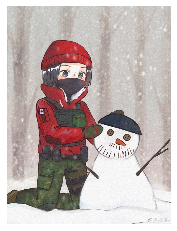

In [2]:
# 图片路径
img_path = 'A.png'

# 以 BGR 方式读取图片
img = cv2.imread(img_path)

# 将 BGR 方式转换为 RGB 方式
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 打印图片类型
print(type(img))

# 展示图片
plt.imshow(img)

# 关闭坐标轴
plt.axis('off')

读取并展示一张图片，下面我们将其封装成为一个方法。

In [3]:
def read_image(img_path):
    """
    读取图片，图片是以 np.array 类型存储
    :param img_path: 图片的路径以及名称
    :return: img np.array 类型存储
    """
    # 读取图片
    img = cv2.imread(img_path) 
    
    # 如果图片是三通道，采用 matplotlib 展示图像时需要先转换通道
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    return img

<class 'numpy.ndarray'>


(-0.5, 827.5, 1103.5, -0.5)

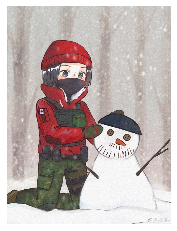

In [4]:
# 加载图片的路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)  

# 读取图片后图片的类型
print(type(img))

# 展示图片
plt.imshow(img)  

# 关闭坐标轴
plt.axis('off') 

+ 展示图片

In [5]:
def plot_image(image, image_title, is_axis=False):
    """
    展示图像
    :param image: 展示的图像，一般是 np.array 类型
    :param image_title: 展示图像的名称
    :param is_axis: 是否需要关闭坐标轴，默认展示坐标轴
    :return:
    """
    # 展示图片
    plt.imshow(image)
    
    # 关闭坐标轴,默认关闭
    if not is_axis:
        plt.axis('off')

    # 展示受损图片的名称
    plt.title(image_title)

    # 展示图片
    plt.show()

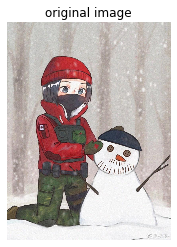

In [6]:
# 加载图片的路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 展示图片
plot_image(image=img, image_title="original image")

## 2.3 保存图片
+ OpenCV 保存一个图片使用函数 [cv2.imwrite(filename, img[, params])](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imread#cv2.imwrite)：
    + filename：保存文件路径及文件名，文件名要加格式
    + img：需要保存的图片

下面我们用 `cv2.imwrite()` 来封装一个保存图片的函数。

In [7]:
def save_image(filename, image):
    """
    将np.ndarray 图像矩阵保存为一张 png 或 jpg 等格式的图片
    :param filename: 图片保存路径及图片名称和格式
    :param image: 图像矩阵，一般为np.array
    :return:
    """
    # np.copy() 函数创建一个副本。
    # 对副本数据进行修改，不会影响到原始数据，它们物理内存不在同一位置。
    img = np.copy(image)
    
    # 从给定数组的形状中删除一维的条目
    img = img.squeeze()
    
    # 将图片数据存储类型改为 np.uint8
    if img.dtype == np.double:
        
        # 若img数据存储类型是 np.double ,则转化为 np.uint8 形式
        img = img * np.iinfo(np.uint8).max
        
        # 转换图片数组数据类型
        img = img.astype(np.uint8)
    
    # 生成图片
    cv2.imwrite(filename, img)

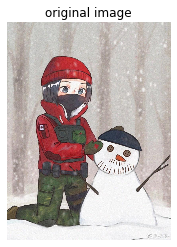

In [8]:
# 图片路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 展示图片
plot_image(image=img, image_title="original image")

# 保存图片，保存成功则文件栏会出现 A_save_img.png
save_image(filename='A_{}_img.png'.format("save"), image=img)

运行上述代码后，图片保存文件栏中。

## 2.4 归一化

+ 机器学习过程中，数据归一化非常重要，归一化的目标主要有：
    + 把数变为（0,1）或者（-1,1）之间的小数
    + 把有量纲表达式变为无量纲表达式  



+ 常见的归一化方法有:<br>
    + 线性比例变换法 $x_i = \frac{x_i}{max(x)}$
    + min-max标准化 $x_i = \frac{x_i-min(x)}{max(x)-min(x)}$
    + z-score 标准化 $x_i = \frac{x_i-mean(x)}{\sigma}$
    
    
    
+ 参考资料：
    + https://blog.csdn.net/pipisorry/article/details/52247379
    + https://blog.csdn.net/zyf89531/article/details/45922151

下面我们来实现线性比例变化法：

In [9]:
def normalization(image):
    """
    将数据线性归一化
    :param image: 图片矩阵，一般是np.array 类型 
    :return: 将归一化后的数据，在（0,1）之间
    """
    # 获取图片数据类型对象的最大值和最小值
    info = np.iinfo(image.dtype)
    
    # 图像数组数据放缩在 0-1 之间
    return image.astype(np.double) / info.max

In [10]:
# 图片的路径和名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 展示部分没有归一化的数据:
print("没有归一化的数据：\n", img[0, 0, :])

# 图片数据归一化
img = normalization(img)

# 展示部分 归一化后的数据
print("归一化后的数据：\n", img[0, 0, :])

没有归一化的数据：
 [186 186 184]
归一化后的数据：
 [0.72941176 0.72941176 0.72156863]


## 2.5 生成受损图像

生成受损图像的实验要求：

+ 受损图像（X）是由原始图像（$I\in R^{H*W*C}$）添加了不同噪声遮罩（noise masks）（$M\in R^{H*W*C}$）得到的（$X=I \bigodot M$），其中 $\bigodot$ 是逐元素相乘。

+ 噪声遮罩仅包含 {0,1} 值。对原图的噪声遮罩的可以每行分别用 0.8/0.4/0.6 的噪声比率产生的，即噪声遮罩每个通道每行 80%/40%/60% 的像素值为0，其他为1。


In [11]:
def noise_mask_image(img, noise_ratio):
    """
    根据题目要求生成受损图片
    :param img: 图像矩阵，一般为 np.ndarray
    :param noise_ratio: 噪声比率，可能值是0.4/0.6/0.8
    :return: noise_img 受损图片, 图像矩阵值 0-1 之间，数据类型为 np.array, 
             数据类型对象 (dtype): np.double, 图像形状:(height,width,channel),通道(channel) 顺序为RGB
    """
    # 受损图片初始化
    noise_img = None

    # -------------实现受损图像答题区域-----------------
    R = np.random.random(img.shape)
    I = np.array(R >= noise_ratio, dtype='double')
    M, N, C = img.shape
    while True:
        total = I.sum() / (M * N * C)
        if abs(total - noise_ratio) <= 3.5:
            break
        R = np.random.random(img.shape)
        I = np.array(R >= noise_ratio, dtype='double')
    noise_img = img * I
    # -----------------------------------------------

    return noise_img

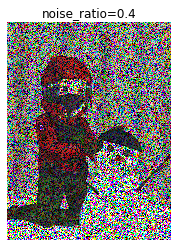

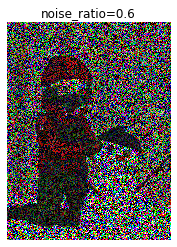

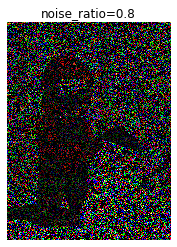

In [12]:
# 不同噪声比率产生的损失图像
noise_ratios = [0.4, 0.6, 0.8]

# 图片路径及名称
img_path = 'A.png'

# 读取图片
img = read_image(img_path)

# 图片数据归一化
nor_img = normalization(img)

for noise_ratio in noise_ratios:
    # 生成受损图片
    noise_img = noise_mask_image(nor_img, noise_ratio)

    # 判断还未生成受损图片时，则提示对方还未生成受损图片，否则展示受损图片
    if noise_img is not None:
        # 展示受损图片
        # 图片名称
        image_title = "noise_ratio=%s" % noise_ratio
        
        # 展示图片
        plot_image(noise_img, image_title)
        
    else:
        print("返回值是 None, 请生成受损图片并返回!")
        break

## 2.6 获取损失图像

In [13]:
def get_noise_mask(noise_img):
    """
    获取噪声图像，一般为 np.array
    :param noise_img: 带有噪声的图片
    :return: 噪声图像矩阵
    """
    # 将图片数据矩阵只包含 0和1,如果不能等于 0 则就是 1。
    return np.array(noise_img != 0, dtype='double')

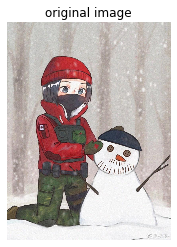

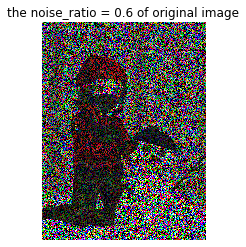

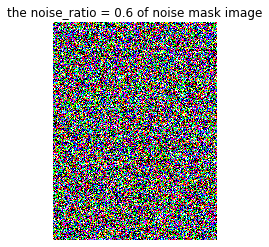

In [14]:
# 展示原始图片、受损图片、噪声图片。
# 原始图片路径
img_path = 'A.png'

# 读取图片
img = read_image(img_path)  

# 展示原始图片
plot_image(image=img, image_title="original image")

# 受损图片部分
# 图像数据归一化
nor_img = normalization(img) 

# 噪声比率
noise_ratio = 0.6

# 生成受损图片
noise_img = noise_mask_image(nor_img, noise_ratio)

if noise_img is None:
    # 未生成受损图片
    print("返回值是 None, 请生成受损图片并返回!")
    
else:
    # 展示受损图片
    plot_image(image=noise_img, image_title="the noise_ratio = %s of original image"%noise_ratio)
    
    # 根据受损图片获取噪声图片
    noise_mask = get_noise_mask(noise_img) 
    
    # 展示噪声图片
    plot_image(image=noise_mask, image_title="the noise_ratio = %s of noise mask image"%noise_ratio)


## 2.7 评估误差

评估误差为所有恢复图像（R）与原始图像（I）的2-范数之和，此误差越小越好。$ \rm error=\sum_{i=1}^{3}norm(R_i(:)-I_i(:),2)$，其中(:)是向量化操作。

理解2-范数参考资料：
+ https://blog.csdn.net/SusanZhang1231/article/details/52127011
+ https://baike.baidu.com/item/%E4%BA%8C%E8%8C%83%E6%95%B0

In [22]:
def compute_error(res_img, img):
    """
    计算恢复图像 res_img 与原始图像 img 的 2-范数
    :param res_img:恢复图像 
    :param img:原始图像 
    :return: 恢复图像 res_img 与原始图像 img 的2-范数
    """
    # 初始化
    error = 0.0
    
    # 将图像矩阵转换成为np.narray
    res_img = np.array(res_img)
    img = np.array(img)
    
    # 如果2个图像的形状不一致，则打印出错误结果，返回值为 None
    if res_img.shape != img.shape:
        print("shape error res_img.shape and img.shape %s != %s" % (res_img.shape, img.shape))
        return None
    
    # 计算图像矩阵之间的评估误差
    error = np.sqrt(np.sum(np.power(res_img - img, 2)))
    
    return round(error,3)

In [23]:
# 计算平面二维向量的 2-范数值 
img0 = [1, 0]
img1 = [0, 1]
print("平面向量的评估误差：", compute_error(img0, img1))

平面向量的评估误差： 1.414


## 2.8 图像恢复

使用**区域二元线性回归模型**进行图像恢复。  

[Scikit-learn](https://scikit-learn.org/stable/index.html) 是 Python 语言的机器学习软件库，Sklearn.linear_model 模型实现了广义线性模型，包括线性回归、Ridge回归、Bayesian回归等。

In [16]:
def restore_image(noise_img, size=4):
    """
    使用 区域二元线性回归模型 进行图像恢复。
    :param noise_img: 一个受损的图像
    :param size: 输入区域半径，长宽是以 size*size 方形区域获取区域, 默认是 4
    :return: res_img 恢复后的图片，图像矩阵值 0-1 之间，数据类型为 np.array,
            数据类型对象 (dtype): np.double, 图像形状:(height,width,channel), 通道(channel) 顺序为RGB
    """
    # 恢复图片初始化，首先 copy 受损图片，然后预测噪声点的坐标后作为返回值。
    res_img = np.copy(noise_img)

    # 获取噪声图像
    noise_mask = get_noise_mask(noise_img)

    # -------------实现图像恢复代码答题区域----------------------------

    # ---------------------------------------------------------------

    return res_img

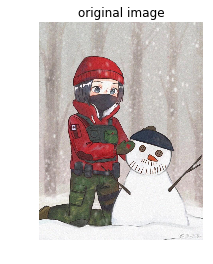

返回值是 None, 请生成受损图片并返回!


In [17]:
# 原始图片
# 加载图片的路径和名称
img_path = 'A.png'

# 读取原始图片
img = read_image(img_path)

# 展示原始图片
plot_image(image=img, image_title="original image")

# 生成受损图片
# 图像数据归一化
nor_img = normalization(img)

# 噪声比率
noise_ratio = 0.6

# 生成受损图片
noise_img = noise_mask_image(nor_img, noise_ratio)

if noise_img is not None:
    # 展示受损图片
    plot_image(image=noise_img, image_title="the noise_ratio = %s of original image"%noise_ratio)

    # 恢复图片
    res_img = restore_image(noise_img)
    
    # 计算恢复图片与原始图片的误差
    print("恢复图片与原始图片的评估误差：", compute_error(res_img, nor_img))

    # 展示恢复图片
    plot_image(image=res_img, image_title="restore image")

    # 保存恢复图片
    save_image('res_' + img_path, res_img)
else:
    # 未生成受损图片
    print("返回值是 None, 请生成受损图片并返回!")


以上就是生成受损图片和恢复图片的全部流程，**提交作业时请注意**：

1. 请你完成生成受损图片 `noise_mask_image()` 和恢复图片 `restore_image()` 部分的代码, 请不要修改函数的输入输出！
2. 提交作业时请导入必要的包和第三方库 (包括此文件中曾经导入过的)。